# Sentiment Twitter Classification

In [223]:
# import dependencies

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pickle

## Data Exploration

In [224]:
df = pd.read_csv('data.csv', encoding='latin-1')

In [225]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


We can see a lot of data that is not important. For example the "Country" feature. Does it matter if the tweet is from the US or from the UK? Probably not. Would this affect the sentiment of the tweet? Probably not. So we won't use this. Same with the "Population -2020", "Land Area (Km^2) "Age of User" ... We will only use the "text" and the "sentiment" features. 

In [226]:
df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [227]:
df.dropna(inplace=True)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB


<Axes: xlabel='sentiment'>

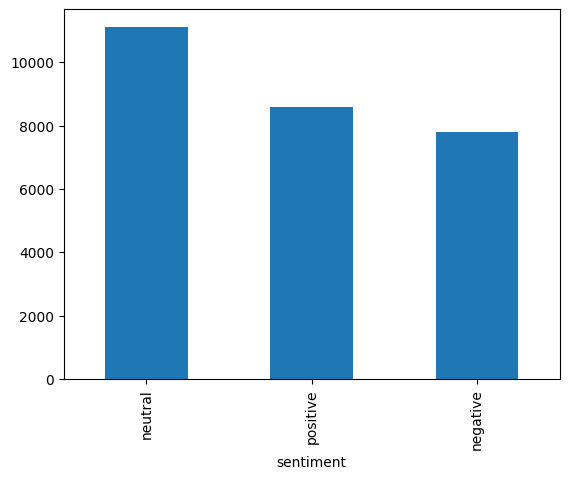

In [229]:
df['sentiment'].value_counts().plot(kind='bar')

## Data Preprocessing

In [230]:
# splitting into train and test sets, use tokenizer to convert text to sequences and pad the sequences to make them of equal length

X = df['text'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (21984,)
Testing Data :  (5496,)


In [231]:
# Encode the string labels into numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert the numerical labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Pickle the label encoder for future use

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

In [232]:
# preprocessing data

def text_preprocessing(text, language, minWordSize):
	# remove non-letters
	text = re.sub('[^a-zA-Z]', ' ', text)
	
	# convert to lower case
	text = text.lower()
	
	# split into words
	words = text.split()

	# remove stop words
	stop_words = set(stopwords.words(language))
	text_no_stop_words = ' '
	words = [w for w in words if not w in stop_words]
	
	# remove words less than minWordSize
	words = [w for w in words if len(w) >= minWordSize]

	# keep 'not' and 'no' ... in stop words
	whitelist = ["n't", "not", "no"]
	for word in text.split():
		if word not in stop_words or word in whitelist:  
			text_no_stop_words = text_no_stop_words + word + ' '

	# do stemming
	text_stemmer = ' '
	stemmer = SnowballStemmer(language)
	for w in text_no_stop_words.split():
		text_stemmer = text_stemmer + stemmer.stem(w) + ' '
	
	# remove short words
	text_no_short_words = ' '
	for w in text_stemmer.split(): 
		if len(w) >=minWordSize:
			text_no_short_words = text_no_short_words + w + ' '
	
	return text_no_short_words

In [233]:
X_train_df = pd.DataFrame(X_train, columns=['text'])
X_test_df = pd.DataFrame(X_test, columns=['text'])

language = 'english'
minWordLength = 2

for i in range(X_train_df.shape[0]):
    X_train_df['text'].iloc[i] = text_preprocessing(X_train_df['text'].iloc[i], language, minWordLength)

for i in range(X_test_df.shape[0]):
    X_test_df['text'].iloc[i] = text_preprocessing(X_test_df['text'].iloc[i], language, minWordLength)

X_train = X_train_df['text'].values
X_test = X_test_df['text'].values

In [234]:
import pickle

# Convert to bag-of-words representation
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit_transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

# Save the CountVectorizer object
with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_bag_of_words)
X_test_tf = tfidf_transformer.transform(X_test_bag_of_words)

# Save the TfidfTransformer object
with open('tfidf_transformer.pkl', 'wb') as f:
    pickle.dump(tfidf_transformer, f)

## Model Creation

In [235]:
# Convert one-hot encoded labels to 1D array
y_train_1d = np.argmax(y_train, axis=1)

model = LogisticRegression()
parameters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}]
grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=4,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train_tf, y_train_1d)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best accuracy:', best_accuracy)
print('Best parameters:', best_parameters)

Best accuracy: 0.6821324599708879
Best parameters: {'C': 1}


c:\Users\denis\.virtualenvs\server-FU8ZmmdG\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Testing

In [236]:
y_pred = grid_search.predict(X_test_tf)

y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_one_hot)
print('Accuracy: ', accuracy)

# classification report
report = classification_report(y_test, y_pred_one_hot)
print('Classification Report:\n', report)

Accuracy:  0.7034206695778749
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1528
           1       0.65      0.75      0.69      2243
           2       0.78      0.71      0.75      1725

   micro avg       0.70      0.70      0.70      5496
   macro avg       0.72      0.70      0.70      5496
weighted avg       0.71      0.70      0.70      5496
 samples avg       0.70      0.70      0.70      5496



In [237]:
import pickle
with open('sentiment_model.pkl', 'wb') as f:
	pickle.dump(grid_search, f)

In [238]:
# Load the saved model
with open('sentiment_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Preprocess new text
new_text = "I went to the movie. It was a good movie. I liked it very much."

preprocessed_text = text_preprocessing(new_text, language, minWordLength)
new_text_bag_of_words = count_vect.transform([preprocessed_text])
new_text_tf = tfidf_transformer.transform(new_text_bag_of_words)

predicted_sentiment = model.predict(new_text_tf)
predicted_sentiment_label = label_encoder.inverse_transform(predicted_sentiment)

print("Predicted sentiment:", predicted_sentiment_label)


Predicted sentiment: ['positive']
